Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


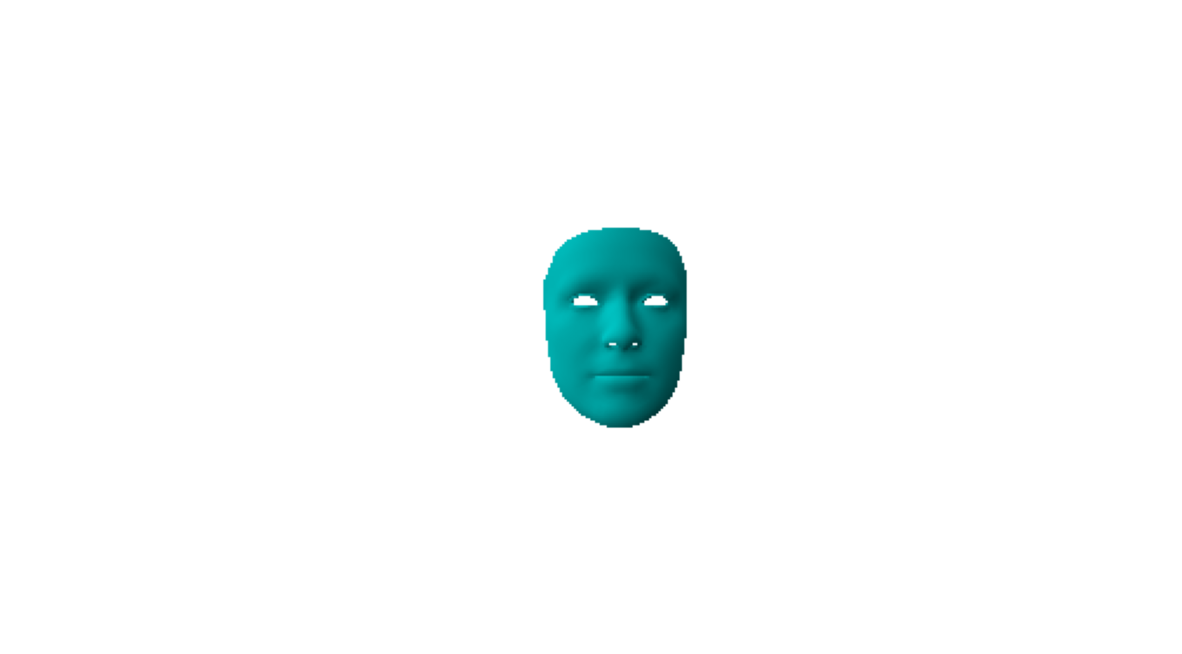

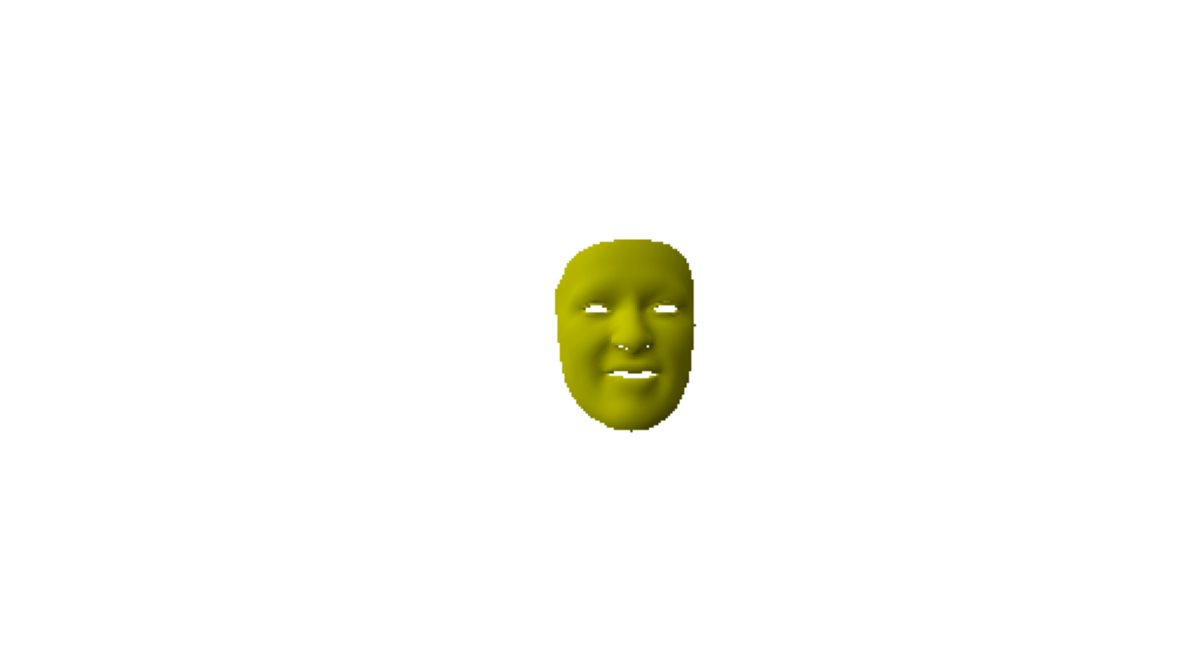

In [2]:
from lib.model.flame.flame import Flame
import torch
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.model.weighting import ResidualWeightModule, DummyWeightModule
from lib.model.correspondence import (
    ProjectiveCorrespondenceModule,
    OpticalFlowCorrespondenceModule,
)
from lib.utils.visualize import visualize_grid, visualize_params
from lib.optimizer.residuals import Point2PlaneResiduals, VertexResiduals
from lib.optimizer.newton import GaussNewton
from lib.optimizer.framework import VertexOptimizer
from lib.data.dataset import SplitDataset 
from torch.utils.data import DataLoader
from lib.optimizer.solver import PytorchSolver

# settings
data_dir = "/home/borth/GuidedResearch/data/dphm_christoph_mouthmove"
flame_dir = "/home/borth/GuidedResearch/checkpoints/flame2023"
device = "cuda" if torch.cuda.is_available() else "cpu"

# setup camera, rasterizer and renderer
K = load_intrinsics(data_dir=data_dir, return_tensor="pt")
camera = Camera(K=K, width=1980, height=1080, scale=4)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)

# setup flame optimizer
flame = Flame(
    flame_dir=flame_dir,
    vertices_mask="face",
    expression_params=50,
    shape_params=100,
)

# creaste gt_params
gt_params = flame.generate_default_params()
gt_params["transl"] = torch.tensor([[0.043, -0.003, -0.528]], device=device)

# initlize params close to gt_params
params = flame.generate_default_params()
params["transl"] = torch.tensor([[0.055, -0.01, -0.548]], device=device)
# params["global_pose"] = torch.tensor([[-0.012, -0.018, -0.005]], device=device)
# params["shape_params"] = torch.rand((1, 100),device=device) * 0.5
params["expression_params"] = torch.rand((1, 50),device=device) * 2.0
# params = flame.generate_default_params()
# params["transl"] = torch.tensor([[0.042, -0.001, -0.538]], device=device)

visualize_params(flame, renderer, gt_params, color=0)
visualize_params(flame, renderer, params, color=2)

In [ ]:
vertex_optimizer = VertexOptimizer(
    flame=flame,
    residuals=VertexResiduals(),
    optimizer=GaussNewton(PytorchSolver()),
    max_iters=2,
)
new_params = vertex_optimizer(s_vertices=batch["vertices"].to("cuda"), params=params)
visualize_params(flame, renderer, new_params, color=1)

In [ ]:
flame_optimizer = FlameOptimizer(
    flame=flame,
    correspondence_module=ProjectiveCorrespondenceModule(),
    weighting_module=DummyWeightModule(),
    renderer=renderer,
    residuals=Point2PlaneResiduals(),
    optimizer=GaussNewton(PytorchSolver()),
    max_iters=5,
    max_optims=1,
)
new_params = flame_optimizer(
    s_point=batch["point"].to("cuda"),
    s_normal=batch["normal"].to("cuda"),
    s_mask=batch["mask"].to("cuda"),
    params=params,
)
visualize_params(flame, renderer, new_params, color=1)
print(flame_optimizer.optimizer.time_tracker.print_summary())

In [ ]:
flame_optimizer = FlameOptimizer(
    flame=flame,
    correspondence_module=OpticalFlowCorrespondenceModule(device=device),
    weighting_module=ResidualWeightModule(device=device),
    renderer=renderer,
    residuals=Point2PlaneResiduals(),
    optimizer=GaussNewton(PytorchSolver(), step_size=0.00001, strategy="forward-mode"),
    max_iters=1,
    max_optims=1,
)
new_params = flame_optimizer(
    s_point=batch["point"].to("cuda"),
    s_normal=batch["normal"].to("cuda"),
    s_mask=batch["mask"].to("cuda"),
    params=params,
)
visualize_params(flame, renderer, new_params, color=1)
print(flame_optimizer.optimizer.time_tracker.print_summary())

In [ ]:
from tqdm import tqdm


def loss_step(params, gt_params):
    loss = []
    for p_names in params.keys():
        l1_loss = torch.abs(params[p_names] - gt_params[p_names])
        loss.append(l1_loss)
    loss = torch.cat(loss, dim=-1).sum()
    return loss


def clone_params(params):
    out = {}
    for k, v in params.items():
        out[k] = v.detach().clone()
    return out


max_steps = 1
flame_optimizer = FlameOptimizer(
    flame=flame,
    correspondence_module=OpticalFlowCorrespondenceModule(device=device),
    weighting_module=ResidualWeightModule(device=device),
    renderer=renderer,
    residuals=Point2PlaneResiduals(),
    optimizer=GaussNewton(PytorchSolver(), step_size=0.01),
    max_iters=4,
    max_optims=3,
)
optimizer = torch.optim.Adam(
    flame_optimizer.w_module.parameters(),
    lr=1e-03,
)

progress = tqdm(total=max_steps, desc="Loop")
for step in range(max_steps):
    optimizer.zero_grad()
    params, gt_params = clone_params(params), clone_params(gt_params)
    batch = next(iter(dataloader))
    new_params = flame_optimizer(
        s_point=batch["point"].to("cuda"),
        s_normal=batch["normal"].to("cuda"),
        s_mask=batch["mask"].to("cuda"),
        params=params,
    )
    default_loss = loss_step(params=params, gt_params=gt_params)
    loss = loss_step(params=new_params, gt_params=gt_params)
    loss.backward()
    optimizer.step()
    progress.update(1)
    progress.set_postfix(
        {
            "loss": float(loss.item()),
            "default_loss": float(default_loss.item()),
        }
    )
progress.close()

In [ ]:
optimizer.state

In [ ]:
optimizer.state[optimizer.param_groups[0]["params"][0]].keys()

In [ ]:
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap, jacfwd
import torch.utils.benchmark as benchmark
from lib.utils.mesh import vertex_normals
from tqdm import tqdm


def train_step(
    batch: dict,
    params: dict,
):
    with torch.no_grad():
        m_out = flame.model_step(**params)
        r_out = flame.render_step(
            renderer=renderer,
            vertices=m_out["vertices"],
        )
        c_out = flame.correspondence_step(
            s_point=batch["point"],
            s_mask=batch["mask"],
            s_normal=batch["normal"],
            t_point=r_out["point"],
            t_mask=r_out["r_mask"],
            t_normal=r_out["normal"],
        )
        mask = c_out["mask"]

    b_depth = batch["point"][..., 2:]  # (B, H, W, 1)
    c_depth = r_out["point"][..., 2:]  # (B, H, W, 1)
    c_normal = r_out["normal"]  # (B, H, W, 3)
    rw_input = torch.cat([b_depth, c_depth, c_normal], dim=-1)
    rw_input = rw_input.permute(0, 3, 1, 2)  # (B, 5, H, W)
    weight_map = residual_weight(rw_input)

    def closure(*args):
        _params = {k: v for k, v in zip(params.keys(), args)}
        m_out = flame.model_step(**_params)
        t_point = interpolate(
            vertices_idx=r_out["vertices_idx"],
            bary_coords=r_out["bary_coords"],
            attributes=m_out["vertices"],
        )
        t_point = t_point[mask]
        s_point = batch["point"][mask]
        t_normal = r_out["normal"][mask]
        weight = weight_map[mask]
        point2plane = ((s_point - t_point) * t_normal).sum(-1)  # (C)
        if "expression_params" in _params:
            regularization = _params["expression_params"].flatten()
            F = torch.cat([weight * point2plane, regularization])
        else:
            F = weight * point2plane
        return F, F

    jacobian_fn = jacfwd(closure, has_aux=True, argnums=tuple(range(len(params))))
    jacobian, F = jacobian_fn(*params.values())
    J = torch.cat([j.flatten(-2) for j in jacobian], dim=-1)  # (M, N)

    # solve for delta
    H = 2 * J.T @ J
    grad_f = 2 * J.T @ F
    delta = -torch.linalg.solve(H, grad_f) * 1e-03

    offset = 0
    out = {}
    for k, param in params.items():
        numel = param.numel()
        d = delta[offset : offset + numel].view_as(param)
        out[k] = param + d
        offset += numel

    return out, weight_map


def loss_step(params, gt_params):
    loss = []
    for p_names in params.keys():
        l1_loss = torch.abs(params[p_names] - gt_params[p_names])
        loss.append(l1_loss)
    loss = torch.cat(loss, dim=-1).sum()
    return loss


def clone_params(params):
    out = {}
    for k, v in params.items():
        out[k] = v.detach().clone()
    return out


def loss_step1(params, batch):
    m_out = flame.model_step(**params)
    r_out = flame.render_step(
        renderer=renderer,
        vertices=m_out["vertices"],
    )
    c_out = flame.correspondence_step(
        s_point=batch["point"],
        s_mask=batch["mask"],
        s_normal=batch["normal"],
        t_point=r_out["point"],
        t_mask=r_out["r_mask"],
        t_normal=r_out["normal"],
    )
    mask = c_out["mask"]
    t_point = interpolate(
        vertices_idx=r_out["vertices_idx"],
        bary_coords=r_out["bary_coords"],
        attributes=m_out["vertices"],
    )
    t_point = t_point[mask]
    s_point = batch["point"][mask]
    t_normal = r_out["normal"][mask]
    point2plane = ((s_point - t_point) * t_normal).sum(-1)  # (C)
    return (point2plane**2).sum()


max_steps = 1000
optimizer = torch.optim.Adam(residual_weight.parameters(), lr=1e-03)

progress = tqdm(total=max_steps, desc="Loop")
for step in range(max_steps):
    optimizer.zero_grad()
    params, gt_params = clone_params(params), clone_params(gt_params)
    batch = create_batch(gt_params)
    new_params, weight_map = train_step(batch=batch, params=params)
    default_loss = loss_step(params=params, gt_params=gt_params)
    loss = loss_step(params=new_params, gt_params=gt_params)
    loss.backward()
    optimizer.step()
    progress.update(1)
    progress.set_postfix(
        {
            "loss": float(loss.item()),
            "default_loss": float(default_loss.item()),
        }
    )
progress.close()

visualize_params(params, 0)
visualize_params(new_params, 1)
visualize_params(gt_params, 2)
visualize_weight_map(weight_map)

In [ ]:
class ParameterStore:
    def generate_random(self, seed: int = 1, sigma: float = 1.0):
        params = {}
        for p_name in self.full_p_names:
            if param := init_config.get(p_name):
                np.random.seed(seed)
                delta = np.random.normal(0, sigma, len(param))
                params[p_name] = [p + d for p, d in zip(param, delta)]
        self.init_params(**params)

In [ ]:
c_module = OpticalFlowCorrespondenceModule(device=device)
m_out = flame(**params)
r_out = renderer.render_full(
    vertices=m_out["vertices"],  # (B, V, 3)
    faces=flame.faces,  # (F, 3)
)
c_out = c_module.predict(
    s_point=batch["point"].to("cuda"),
    s_normal=batch["normal"].to("cuda"),
    t_point=r_out["point"],
    t_normal=r_out["normal"],
)
value = r_out["point"]
grid = c_module.create_grid(c_out["s_delta"])

In [ ]:
import torch.utils.benchmark as benchmark

def sample_grid1(grid: torch.Tensor, value: torch.Tensor):
    B, H, W, C = value.shape

    # scale grid values from [-1, 1] to [0, W-1] for x and [0, H-1] for y
    x = ((grid[..., 0] + 1) * (W - 1)) / 2
    y = ((grid[..., 1] + 1) * (H - 1)) / 2

    # ...

    # bilinear interpolate the cornes
    interpolated_values = (
        wa.unsqueeze(-1) * Ia
        + wb.unsqueeze(-1) * Ib
        + wc.unsqueeze(-1) * Ic
        + wd.unsqueeze(-1) * Id
    )

    # zero out the where we need to clamp
    zero_tensor = torch.zeros_like(interpolated_values)
    interpolated_values[clamp_mask] = zero_tensor[clamp_mask]

    return interpolated_values


def sample_grid2(grid: torch.Tensor, value: torch.Tensor):
    value = value.permute(0, 3, 1, 2)
    samples = torch.nn.functional.grid_sample(
        input=value,
        grid=grid,
        mode="bilinear",
        align_corners=False,
        padding_mode="zeros",
    )
    samples = samples.permute(0, 2, 3, 1)
    return samples


def foo():
    sample_grid2(grid, value)

t0 = benchmark.Timer(
    stmt="foo()",
    setup="from __main__ import foo",
    globals=globals(),
)
print(t0.timeit(200))

In [ ]:
from lib.tracker.logger import FlameLogger

logger = FlameLogger(mode="joint")